In [16]:
import numpy as np 
import pandas as pd 

In [17]:
df = pd.read_csv("NLP_exam_emotions_dataset/train.txt",sep=";",names=["Description","Emotion"])
df.head(5)

,Description,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [18]:
df['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

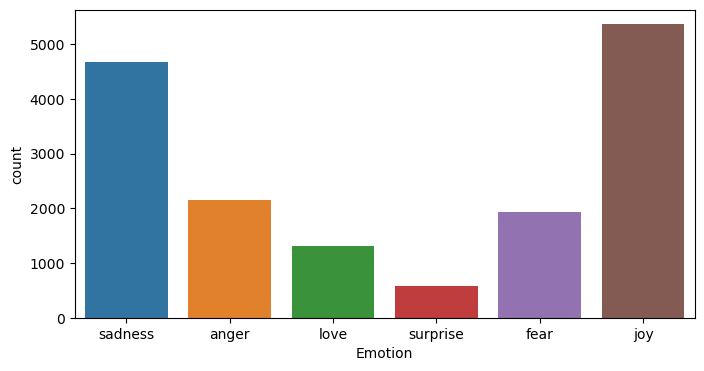

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df);

In [25]:
df.isnull().sum()

Description    0
Emotion        0
dtype: int64

In [20]:
print(df.shape)

(16000, 2)


In [8]:
df['label_num'] = df['Emotion'].map({
    'joy' : 0, 
    'sadness': 1, 
    'anger': 2, 
    'fear': 3,
    'love': 4,
    'surprise':5
})


df.head(5)

,Description,Emotion,label_num
0,i didnt feel humiliated,sadness,1
1,i can go from feeling so hopeless to so damned...,sadness,1
2,im grabbing a minute to post i feel greedy wrong,anger,2
3,i am ever feeling nostalgic about the fireplac...,love,4
4,i am feeling grouchy,anger,2


In [14]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['Emotion'])

In [15]:
df[['Emotion','label_enc']].drop_duplicates(keep='first')

,Emotion,label_enc
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [31]:
#object of WordNetLemmatizer
wordnet = WordNetLemmatizer()
corpus=[]
for i in range(len(df)):
    review= re.sub('[^a-zAZ]',' ',df['Description'][i])
    review= review.lower()
    review= review.split()
    review= [wordnet.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review= ' '.join(review)
    corpus.append(review)
    

In [32]:
corpus[1]

'go feeling hopeless damned hopeful around someone care awake'

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
traindata= cv.fit_transform(corpus)
X= traindata 
y= df.Emotion 
X.shape,y.shape

((16000, 13458), (16000,))

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Load the dataset
df = pd.read_csv("NLP_exam_emotions_dataset/train.txt", sep=";", names=["Description", "Emotion"])

# Preprocess the text data
stop_words = set(stopwords.words('english'))
wordnet = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [wordnet.lemmatize(word) for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

df['Processed_Text'] = df['Description'].apply(preprocess_text)

# Split the data into training and testing sets
X = df['Processed_Text']
y = df['Emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Fully Connected Neural Network

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

model_fcnn = Sequential()
model_fcnn.add(Dense(128, activation='relu', input_shape=(X_train_vec.shape[1],)))
model_fcnn.add(Dropout(0.2))
model_fcnn.add(Dense(64, activation='relu'))
model_fcnn.add(Dropout(0.2))
model_fcnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_fcnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_fcnn.fit(X_train_vec, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_test_vec, y_test_encoded))


Epoch 1/10
400/400 [==============================] - 9s 14ms/step - loss: 0.9317 - accuracy: 0.6705 - val_loss: 0.3747 - val_accuracy: 0.8703
Epoch 2/10
400/400 [==============================] - 5s 12ms/step - loss: 0.1969 - accuracy: 0.9379 - val_loss: 0.3398 - val_accuracy: 0.8831
Epoch 3/10
400/400 [==============================] - 5s 12ms/step - loss: 0.0819 - accuracy: 0.9740 - val_loss: 0.3830 - val_accuracy: 0.8788
Epoch 4/10
400/400 [==============================] - 5s 12ms/step - loss: 0.0494 - accuracy: 0.9849 - val_loss: 0.4245 - val_accuracy: 0.8772
Epoch 5/10
400/400 [==============================] - 5s 12ms/step - loss: 0.0351 - accuracy: 0.9889 - val_loss: 0.4598 - val_accuracy: 0.8766
Epoch 6/10
400/400 [==============================] - 5s 12ms/step - loss: 0.0262 - accuracy: 0.9924 - val_loss: 0.5175 - val_accuracy: 0.8703
Epoch 7/10
400/400 [==============================] - 5s 12ms/step - loss: 0.0235 - accuracy: 0.9924 - val_loss: 0.5530 - val_accuracy: 0.8728

# Recurrent Neural Network (RNN) with LSTM 

In [43]:
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


max_sequence_length = 100 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)


model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model_rnn.add(LSTM(128))
model_rnn.add(Dense(len(label_encoder.classes_), activation='softmax'))


model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_rnn.fit(X_train_pad, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test_encoded))


Epoch 1/10
400/400 [==============================] - 42s 91ms/step - loss: 1.1804 - accuracy: 0.5765 - val_loss: 0.5321 - val_accuracy: 0.8231
Epoch 2/10
400/400 [==============================] - 40s 100ms/step - loss: 0.2415 - accuracy: 0.9209 - val_loss: 0.3034 - val_accuracy: 0.8909
Epoch 3/10
400/400 [==============================] - 38s 95ms/step - loss: 0.0996 - accuracy: 0.9673 - val_loss: 0.3067 - val_accuracy: 0.8956
Epoch 4/10
400/400 [==============================] - 38s 96ms/step - loss: 0.0591 - accuracy: 0.9809 - val_loss: 0.3263 - val_accuracy: 0.8966
Epoch 5/10
400/400 [==============================] - 41s 101ms/step - loss: 0.0412 - accuracy: 0.9862 - val_loss: 0.3569 - val_accuracy: 0.9028
Epoch 6/10
400/400 [==============================] - 38s 96ms/step - loss: 0.0324 - accuracy: 0.9901 - val_loss: 0.3845 - val_accuracy: 0.8981
Epoch 7/10
400/400 [==============================] - 38s 96ms/step - loss: 0.0311 - accuracy: 0.9895 - val_loss: 0.3704 - val_accurac

# Fine-tuned Transformer Architecture

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import classification_report
import tensorflow as tf

tokenizer_transformer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_transformer = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))


X_train_transformer = tokenizer_transformer.batch_encode_plus(
    X_train.tolist(),
    truncation=True,
    max_length=128,
    padding='max_length',
    return_token_type_ids=False
)

X_test_transformer = tokenizer_transformer.batch_encode_plus(
    X_test.tolist(),
    truncation=True,
    max_length=128,
    padding='max_length',
    return_token_type_ids=False
)


train_dataset_transformer = tf.data.Dataset.from_tensor_slices((
    dict(X_train_transformer),
    y_train_encoded
))

test_dataset_transformer = tf.data.Dataset.from_tensor_slices((
    dict(X_test_transformer),
    y_test_encoded
))


optimizer_transformer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_transformer = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_transformer = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model_transformer.compile(optimizer=optimizer_transformer, loss=loss_transformer, metrics=[metric_transformer])
model_transformer.fit(train_dataset_transformer.shuffle(100).batch(16), epochs=3)


preds_transformer = model_transformer.predict(test_dataset_transformer.batch(16)).logits.numpy().argmax(axis=-1)
classification_report_transformer = classification_report(y_test_encoded, preds_transformer, target_names=label_encoder.classes_)
print(classification_report_transformer)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
 28/800 [>.............................] - ETA: 1:43:48 - loss: 1.5833 - accuracy: 0.3951

# Compare the different models to find the best approach

100/100 [==============================] - 4s 35ms/step
Recurrent Neural Network (RNN) Evaluation:
Accuracy: 0.8959375
Classification Report:
               precision    recall  f1-score   support

       anger       0.90      0.90      0.90       427
        fear       0.89      0.85      0.87       397
         joy       0.92      0.92      0.92      1021
        love       0.79      0.76      0.78       296
     sadness       0.92      0.95      0.93       946
    surprise       0.79      0.74      0.77       113

    accuracy                           0.90      3200
   macro avg       0.87      0.85      0.86      3200
weighted avg       0.90      0.90      0.90      3200

Confusion Matrix:
 [[383   8   9   4  20   3]
 [ 21 336  10   1  15  14]
 [  1   3 941  50  23   3]
 [  4   4  47 226  15   0]
 [ 17  10  16   4 897   2]
 [  0  16   5   0   8  84]]


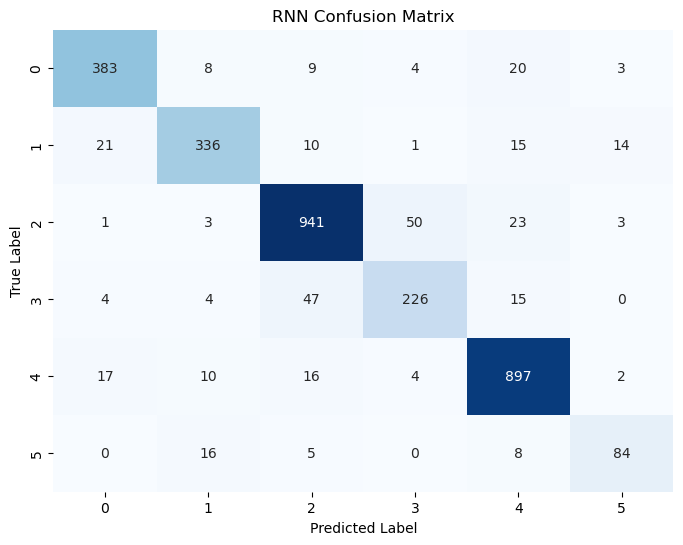

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_rnn_prob = model_rnn.predict(X_test_pad_seq)
y_pred_rnn = np.argmax(y_pred_rnn_prob, axis=1)
accuracy_rnn = accuracy_score(y_test_encoded, y_pred_rnn)
classification_report_rnn = classification_report(y_test_encoded, y_pred_rnn, target_names=label_encoder.classes_)
confusion_matrix_rnn = confusion_matrix(y_test_encoded, y_pred_rnn)

# Print and visualize the evaluation results
print("Recurrent Neural Network (RNN) Evaluation:")
print("Accuracy:", accuracy_rnn)
print("Classification Report:\n", classification_report_rnn)
print("Confusion Matrix:\n", confusion_matrix_rnn)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_rnn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("RNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# duplicate it on a “reallife”text classification approach